In [ ]:
!pip install pyspark -q

In [ ]:
!pip install delta-spark==3.2.0 -q

In [ ]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
builder = (
SparkSession.builder.appName("DeltaDemo")
.config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
.config("spark.sql.catalog.spark_catalog",
"org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()
# Create sample DataFrame
data = [
(1, "John", "Electronics", 2, 300),
(2, "Sara", "Clothing", 1, 50),
(3, "Mike", "Electronics", 4, 600),
(4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)
# Save as Delta table
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

# **1**. Managed vs Unmanaged Tables

In [ ]:
spark.sql("CREATE TABLE orders_managed USING DELTA LOCATION '/tmp/orders_delta'")

spark.sql("CREATE TABLE orders_unmanaged USING DELTA LOCATION '/tmp/orders_delta'")

DataFrame[]

In [ ]:
print("📌 Managed Table Data:")
spark.sql("SELECT * FROM orders_managed").show()

print("📌 Unmanaged Table Data:")
spark.sql("SELECT * FROM orders_unmanaged").show()


📌 Managed Table Data:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+

📌 Unmanaged Table Data:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



In [ ]:
managed_location = spark.sql("DESCRIBE DETAIL orders_managed").collect()[0]["location"]
unmanaged_location = spark.sql("DESCRIBE DETAIL orders_unmanaged").collect()[0]["location"]

print("Managed table location:", managed_location)
print("Unmanaged table location:", unmanaged_location)

Managed table location: file:/tmp/orders_delta
Unmanaged table location: file:/tmp/orders_delta


**2. CRUD Operations**

Task:

Read from the table

Update all "Clothing" category orders to have amount = amount + 20

Delete all orders with quantity < 2

Merge in a new dataset (new orders & updated orders)

In [ ]:
#Load as DeltaTable
from delta.tables import *
delta_path = "/tmp/orders_delta"
delta_table = DeltaTable.forPath(spark, delta_path)
delta_table.toDF().show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



In [ ]:
#UPDATE: Add 20 to Clothing category amounts

delta_table.update(
    condition="category = 'Clothing'",
    set={"amount": "amount + 20"}
)

In [ ]:
print("After UPDATE:")
delta_table.toDF().show()


After UPDATE:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



In [ ]:
#DELETE: Remove orders with quantity < 2

delta_table.delete("quantity < 2")

print("After DELETE:")
delta_table.toDF().show()


After DELETE:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       6|         Emma|   Clothing|       2|   120|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



In [ ]:
#MERGE: New dataset (some updates + some new)
new_data = [
    (3, "Mike", "Electronics", 5, 750),   # Updated quantity & amount for order_id 3
    (5, "Liam", "Furniture", 1, 200),     # New order
    (6, "Emma", "Clothing", 2, 120),      # New order
]
df_new = spark.createDataFrame(new_data, columns)

delta_table.alias("old").merge(
    df_new.alias("new"),
    "old.order_id = new.order_id"
).whenMatchedUpdateAll(
).whenNotMatchedInsertAll(
).execute()

print("After MERGE:")
delta_table.toDF().show()

After MERGE:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|  Furniture|       1|   200|
|       6|         Emma|   Clothing|       2|   120|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



#**3. History & Time Travel**
Task:

Use DESCRIBE HISTORY to check previous versions

Read data from version 0 and compare with the latest version

In [ ]:

#HISTORY: View previous versions

print("📜 Delta Table History:")
delta_table.history().show(truncate=False)

# TIME TRAVEL: Read version 0

print("📌 Data at Version 0:")
df_v0 = spark.read.format("delta").option("versionAsOf", 0).load(delta_path)
df_v0.show()

# TIME TRAVEL: Read latest version

print("📌 Data at Latest Version:")
df_latest = spark.read.format("delta").load(delta_path)
df_latest.show()


#  Comparison

print("📊 Changes between Version 0 and Latest:")
df_v0.createOrReplaceTempView("v0")
df_latest.createOrReplaceTempView("v_latest")

spark.sql("""
SELECT 'Removed from v0' AS change_type, *
FROM v0
WHERE order_id NOT IN (SELECT order_id FROM v_latest)
UNION ALL
SELECT 'Added in latest' AS change_type, *
FROM v_latest
WHERE order_id NOT IN (SELECT order_id FROM v0)
UNION ALL
SELECT 'Modified in latest' AS change_type, v_latest.*
FROM v_latest
JOIN v0 USING (order_id)
WHERE v_latest.quantity <> v0.quantity
   OR v_latest.amount <> v0.amount
""").show()


📜 Delta Table History:
+-------+-----------------------+------+--------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-------------------

# **4. Incremental Load Pattern**
Task:

Create a new mini-batch with only new orders (IDs 5 & 6)

Append to the Delta table

Show final result

In [ ]:

#  INCREMENTAL LOAD


from pyspark.sql import Row

# New mini-batch with only new orders
new_data = [
    Row(order_id=5, customer_name="Liam", category="Electronics", quantity=1, amount=200),
    Row(order_id=6, customer_name="Emma", category="Clothing", quantity=2, amount=80)
]

df_new_orders = spark.createDataFrame(new_data)

print(" New Incremental Batch:")
df_new_orders.show()

#  Append to the Delta table
df_new_orders.write.format("delta").mode("append").save(delta_path)

# Show final result after incremental load
print("Final Delta Table After Incremental Load:")
spark.read.format("delta").load(delta_path).show()


📦 New Incremental Batch:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       5|         Liam|Electronics|       1|   200|
|       6|         Emma|   Clothing|       2|    80|
+--------+-------------+-----------+--------+------+

✅ Final Delta Table After Incremental Load:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       6|         Emma|   Clothing|       2|   120|
|       5|         Liam|Electronics|       1|   200|
|       1|         John|Electronics|       2|   300|
|       6|         Emma|   Clothing|       2|    80|
+--------+-------------+-----------+--------+------+



# **5. Simple Streaming Read**
Task:

Read the /tmp/orders_delta in streaming mode

Output to console every 5 seconds

In [ ]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

# Initialize Spark (if not already running)
builder = (
    SparkSession.builder.appName("DeltaStreamingDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

delta_path = "/tmp/orders_delta"

# Streaming Read
stream_df = (
    spark.readStream
    .format("delta")
    .load(delta_path)
)

# Streaming Write to console every 5 seconds
query = (
    stream_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)

# Keep running for ~30 seconds



In [ ]:
import time

# Path to the Delta table
delta_path = "/tmp/orders_delta"

# Example new batches of data
batches = [
    [
        (11, "Alice", "Electronics", 1, 120),
        (18, "Bob", "Clothing", 2, 80)
    ],
    [
        (19, "Chaplin", "Electronics", 3, 450),
        (20, "Daisy", "Clothing", 1, 70)
    ]
]

columns = ["order_id", "customer_name", "category", "quantity", "amount"]

# Append batches with delay so streaming picks them up
for batch in batches:
    df_new = spark.createDataFrame(batch, columns)
    df_new.write.format("delta").mode("append").save(delta_path)
    print(f"Appended batch: {batch}")
    time.sleep(6)  # Wait 6 seconds to let streaming display


Appended batch: [(11, 'Alice', 'Electronics', 1, 120), (18, 'Bob', 'Clothing', 2, 80)]
Appended batch: [(19, 'Chaplin', 'Electronics', 3, 450), (20, 'Daisy', 'Clothing', 1, 70)]


In [ ]:
# Start streaming into memory table
stream = (
    spark.readStream.format("delta")
    .load("/tmp/orders_delta")
    .writeStream
    .format("memory")
    .queryName("orders_stream")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)

# Poll data every few seconds
import time
for i in range(5):  # check 5 times
    time.sleep(5)
    print(f"--- Batch {i+1} ---")
    spark.sql("SELECT * FROM orders_stream").show()


--- Batch 1 ---
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       6|         Emma|   Clothing|       2|   120|
|       9|      Charlie|Electronics|       3|   450|
|       7|        Alice|Electronics|       1|   120|
|       1|         John|Electronics|       2|   300|
|       5|         Liam|Electronics|       1|   200|
|      10|        Daisy|   Clothing|       1|    70|
|       6|         Emma|   Clothing|       2|    80|
|       8|          Bob|   Clothing|       2|    80|
+--------+-------------+-----------+--------+------+

--- Batch 2 ---
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|   

In [ ]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

# Create Spark session with Delta support (if not already created)
builder = (
    SparkSession.builder.appName("DeltaStreaming1Demo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Start streaming into memory table
stream = (
    spark.readStream.format("delta")
    .load("/tmp/orders_delta")
    .writeStream
    .format("memory")
    .queryName("orders1_stream")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)


In [ ]:
import time

for i in range(5):  # Check 5 times (every 5 seconds)
    time.sleep(5)
    print(f"--- Batch {i+1} ---")
    spark.sql("SELECT * FROM orders_stream").show()


--- Batch 1 ---
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       6|         Emma|   Clothing|       2|   120|
|       9|      Charlie|Electronics|       3|   450|
|       7|        Alice|Electronics|       1|   120|
|       1|         John|Electronics|       2|   300|
|       5|         Liam|Electronics|       1|   200|
|      10|        Daisy|   Clothing|       1|    70|
|       6|         Emma|   Clothing|       2|    80|
|       8|          Bob|   Clothing|       2|    80|
|      11|        Alice|Electronics|       1|   120|
|      18|          Bob|   Clothing|       2|    80|
|      19|      Chaplin|Electronics|       3|   450|
|      20|        Daisy|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+

--- Batch 2 ---
+--------+---

# **6. Visualization**
Task:

Read Delta table into Pandas

Create a bar chart of category vs total amount

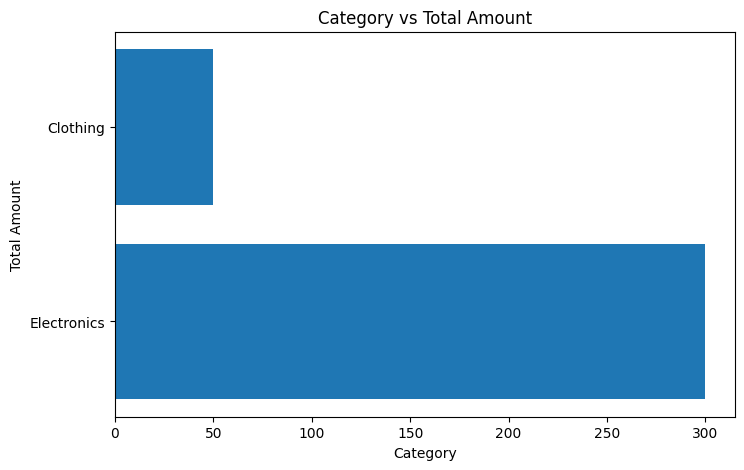

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read Delta table into Spark DataFrame
df_spark = spark.read.format("delta").load("/tmp/orders_delta")

# Aggregate total amount by category
df_spark_grouped = df_spark.groupBy("category").sum("amount").withColumnRenamed("sum(amount)", "total_amount")

# Convert to Pandas DataFrame
df_pandas = df_spark_grouped.toPandas()

# Plot
plt.figure(figsize=(8,5))
plt.barh(df_pandas["category"], df_pandas["total_amount"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()
